### On abandonne la piste des clusters et on se concentre sur l'évolution temporelle de l'indice de cohésion par groupe politique

**Indice de cohésion**

Le taux de cohésion d'un groupe politique mesure le degré d'unité du groupe quand il vote. Plusieurs formules existent dans la litérature académique. Nous avons choisi la mesure "Agreement Index" développé par Simon Hix, Abdul G. Noury et Gérard Roland, qui se calcule de la façon suivante : Ai=(max(Y,N,A)-(0.5((Y+N+A)-max(Y,N,A))))/(Y+N+A), où Y = nombre de votes "pour", N = nombre de votes "contre", et A = nombre d'abstentions. Nous avons mesuré l'index de cohésion pour chaque groupe et chaque vote. Cet index peut prendre des valeurs comprises entre 0 et 1, 0 correspondant à un groupe complètement divisé et 1 à un groupe où tous ses députés ont voté la même chose. Le taux de cohésion qui se trouve sur les pages des groupes politiques correspond à la moyenne des taux de cohésion pour ce groupe pour tous les votes.

À savoir, dans beaucoup de parlements, y compris à l'Assemblée nationale, les députés suivent souvent la ligne officielle du groupe politique. Autrement dit, quand il s'agit de voter, la cohésion des groupes politiques est relativement élevée. Tout d'abord, les députés membres d'un groupe politique sont généralement proches idéologiquement, et donc sont amenés à avoir la même position quand il s'agit de voter. De plus, les groupes peuvent exercer des pressions pour inciter les députés à être loyaux, autrement dit à voter comme la ligne officielle du groupe, favorisant ainsi la cohésion au sein du groupe. La mesure de cohésion proposée est donc intéressante quand elle est comparée aux taux de cohésion des autres groupes parlementaires.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_votes = pd.read_csv('database_votes2.csv', index_col=0)

In [3]:
abst = pd.read_csv('abst.csv')

In [4]:
df_votes = df_votes.merge(abst, on = 'idScrutin', how ='left')

In [5]:
#on veut compter le nombre de 'Pour', 'Contre', 'Non-Votant' par parti par scrutin
#Ai=(max(Y,N,A)-(0.5((Y+N+A)-max(Y,N,A))))/(Y+N+A), 
#où Y = nombre de votes "pour", N = nombre de votes "contre", et A = nombre d'abstentions

In [6]:
pour = df_votes[df_votes['vote'].isin(['Pour'])].groupby(['Groupe politique (complet)', 'idScrutin']).count()[['vote']]
contre = df_votes[df_votes['vote'].isin(['Contre'])].groupby(['Groupe politique (complet)', 'idScrutin']).count()[['vote']]

In [7]:
pour = pour.rename(columns = {'vote' : 'nbr_pour'})
contre = contre.rename(columns = {'vote' : 'nbr_contre'})
pour = pd.DataFrame(pour)

In [8]:
def agreement_index(pour, contre, nonvot):
    return(max(pour, contre, nonvot) - (0.5*((pour+contre+nonvot)-max(pour,contre,nonvot))))/(pour+contre+nonvot)

In [9]:
#### ATTENTION IL FAUT SORT VALUES PAR LA DATE DU SCRUTIN AVANT 

In [10]:
#On ordonne chronologiquement les identifiants des scrutins 
scrutins_chrono = df_votes[['idScrutin', 'date_scrutin']].sort_values('date_scrutin').drop_duplicates()

In [11]:
namespace = globals()
groupes = df_votes['Groupe politique (complet)'].unique()

effectifs = []
for groupe in groupes : 
    effectif = len(df_votes[df_votes['Groupe politique (complet)'].isin([groupe])]['idVotant'].unique())
    effectifs.append(effectif)

for groupe in range(len(groupes)):
    namespace['AI_%d' % groupe] = []
    test = df_votes[df_votes['Groupe politique (complet)'].isin([groupes[groupe]])]
    for scrutin in list(scrutins_chrono['idScrutin']):
        test2 = test[test['idScrutin']==scrutin]
        pour = test2[test2['vote'].isin(['Pour'])].count()[0]
        contre = test2[test2['vote'].isin(['Contre'])].count()[0]
        nonvot = effectifs[groupe] - (pour+contre)
        AI = agreement_index(pour, contre, nonvot)
        namespace['AI_%d' % groupe].append(AI) 

On a calculé l'agreement index pour tous les partis pour tous les scrutins mais ça fait beaucoup, il faut faire des moyennes tous les 200 scrutins. 

In [12]:
import statistics
for groupe in range(len(groupes)):
    namespace['AI_mean_%d' % groupe] = []
    for i in range(15):
        transit = namespace['AI_%d' % groupe][:200]
        del namespace['AI_%d' % groupe][:200]
        mean = statistics.mean(transit)
        namespace['AI_mean_%d' % groupe].append(mean)
    transit = namespace['AI_%d' % groupe]
    mean = statistics.mean(transit)
    namespace['AI_mean_%d' % groupe].append(mean)

In [13]:
#On uniformise les couleurs avec tous les graph du rapport 
color_dict = {'Socialistes et apparentés' : 'r',
              'Les Républicains' : 'b',
              'Non inscrit' : 'silver',
              'Mouvement Démocrate (MoDem) et Démocrates apparentés' : 'gold',
              'Libertés et Territoires' : 'dodgerblue', 
              'La France insoumise' : 'darkred',
              'La République en Marche' : 'darkorange', 
              'UDI et Indépendants' : 'cornflowerblue',
              'Gauche démocrate et républicaine' : 'tomato', 
              'Agir ensemble' : 'paleturquoise'}

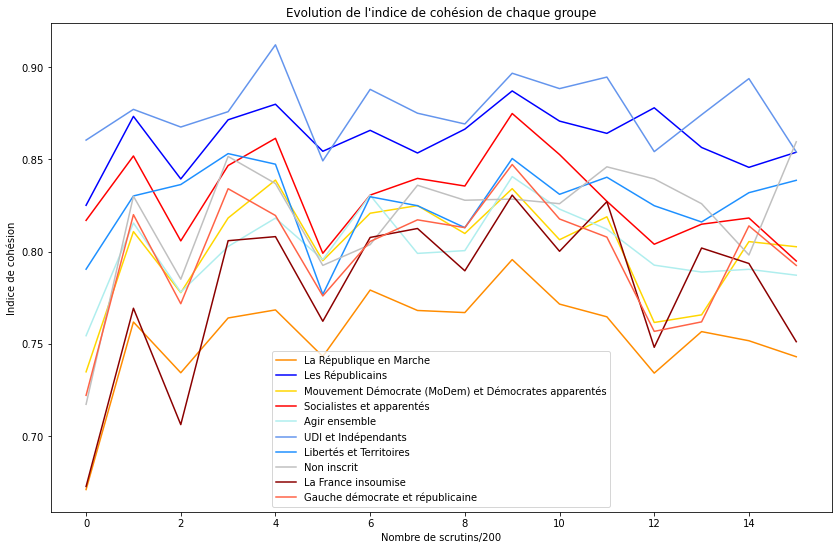

In [16]:
plt.figure(figsize=(14,9)) 

for groupe in range(len(groupes)):
    color = color_dict[groupes[groupe]]
    plt.plot(namespace['AI_mean_%d' % groupe], label = groupes[groupe], color = color)
    
    

plt.title("Evolution de l'indice de cohésion de chaque groupe")
plt.ylabel("Indice de cohésion")
plt.xlabel("Nombre de scrutins/200")
plt.legend(loc = 'lower center')

On veut récupérer les dates pour avoir une courbe en fonction du temps et pas en fonction du nombre de scrutins

In [17]:
dates = []
liste = list(scrutins_chrono['date_scrutin'])
for i in range(15):
    date_debut = liste[0]
    date_fin = liste[199]
    del liste[:200]
    dates.append(date_debut)
    dates.append(date_fin)
date_debut = liste[0]
date_fin = liste[116]
dates.append(date_debut)
dates.append(date_fin)

In [18]:
import datetime
from datetime import timedelta

mid_dates = []

for i in range(0,len(dates),2):
    start_date = datetime.datetime.strptime(dates[i],'%Y-%m-%d')
    end_date = datetime.datetime.strptime(dates[i+1],'%Y-%m-%d')
    difference_in_days = abs((end_date - start_date).days)
    mid_date = start_date + timedelta(difference_in_days/2)
    mid_dates.append(mid_date)

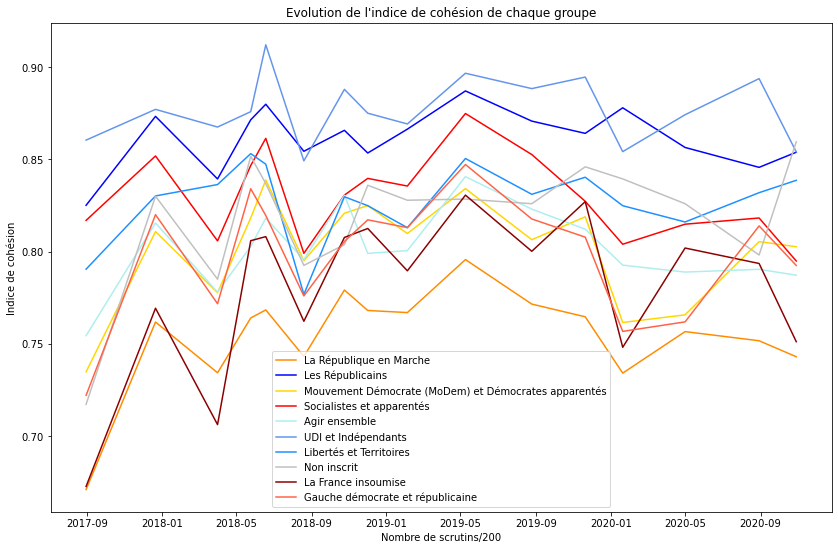

In [19]:
plt.figure(figsize=(14,9)) 
x = mid_dates
for groupe in range(len(groupes)):
    color = color_dict[groupes[groupe]]
    plt.plot(x, namespace['AI_mean_%d' % groupe], label = groupes[groupe], color = color)
    
    

plt.title("Evolution de l'indice de cohésion de chaque groupe")
plt.ylabel("Indice de cohésion")
plt.xlabel("Nombre de scrutins/200")
plt.legend(loc = 'lower center')